#Homework 2: Turnover prediction (IBM dataset)

###Steps
1. Load packages and data
2. Separate numeric and object vars
3. Drop var=0 numeric and unique value=1 object vars
4. For numerics:
  - Plot corr and drop some of the numeric:
  - corr between two features >= 0.75
  - corr between target is lowest
  - Plot histograms for the next (for further transformations)
5. For objects:
  - separate unique values = 2 and > 2
  - for = 2 encode into categories and join to numeric
  - for > 3 observe to get dummies, encode categories or transform
6. Set yp default models but with balanced classes
7. Run GridSearch for CART with CV=3 (as data is small) and score ROC_AUC
8. Use best paramts for tree and default for logit to fit and score
9. Get important features from tree, use them only to fit both models
10. Next (for better accuracy):
  - Scale data and clean outliers, if any
  - Transform features
  - Use ensembles instead of single tree
  - Regularize logistic regression

In [0]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# to avoid calling plt.show() everytime
%matplotlib inline

In [0]:
people_data = pd.read_csv('https://raw.githubusercontent.com/HrantDavtyan/BA_BA/master/IBM_people_dataset.csv')

In [3]:
#separate numeric and object variables
data_numeric = people_data.select_dtypes(exclude="object")
data_object = people_data.select_dtypes(include="object")

#choose numeric vars with non-zero variance
print("Numeric")
print("Before: ",len(data_numeric.columns))
data_numeric = data_numeric.loc[:,data_numeric.var()!=0]
print("After: ",len(data_numeric.columns))

print("\n") #break line in output

#choose object vars with more than 1 unique value
print("Objects")
print("Before: ",len(data_object.columns))
data_object = data_object.loc[:,[len(data_object[i].unique())>1 for i in data_object.columns]]
print("After: ",len(data_object.columns))

#choose object vars with only 2 values, encode and join back to numerics
data_encode = data_object.loc[:,[len(data_object[i].unique())==2 for i in data_object.columns]]
data_encode = data_encode.apply(LabelEncoder().fit_transform)
data_numeric = data_numeric.join(data_encode)

#choose object vars with more than 2 values and observe
data_dummy = data_object.loc[:,[len(data_object[i].unique())>2 for i in data_object.columns]]

Numeric
Before:  26
After:  24


Objects
Before:  9
After:  8


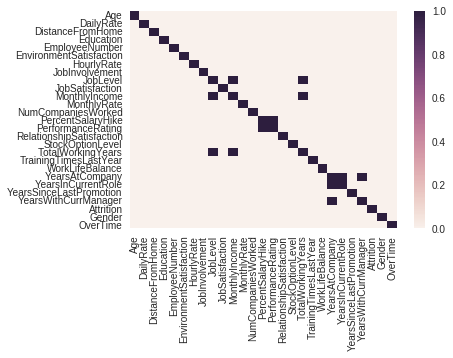

In [4]:
#visualize corr that are at least 75% in absolute value
sns.heatmap(data_numeric.corr().abs()>=0.75)

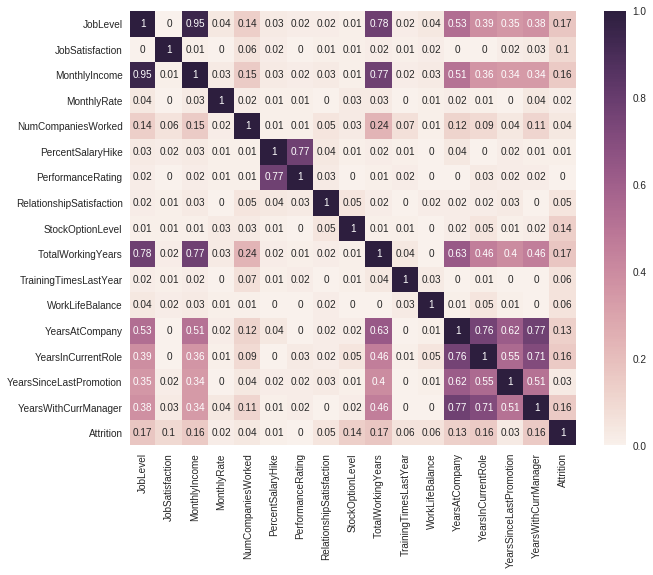

In [5]:
#choose starting from the 9th columns (as no high corr before)
# and until the last 2 (not include as again no high corr)
#annotate the matrix with corr coeficient rounded up to 2
#set bigger figure size (in inches) for better visibility
plt.figure(figsize=(10, 8))
sns.heatmap(data_numeric.iloc[:,8:-2].corr().abs().round(2),annot=True)

In [0]:
#vars to consider: "JobLevel", "MonthlyIncome", "TotalWorkingYears",
# "PerformanceRating","PercentSalaryHike","YearsAtCompany","YearsInCurrentRole","YearsWithCurrManager"
data_numeric = data_numeric.drop(["YearsAtCompany","TotalWorkingYears","PerformanceRating"],axis=1)

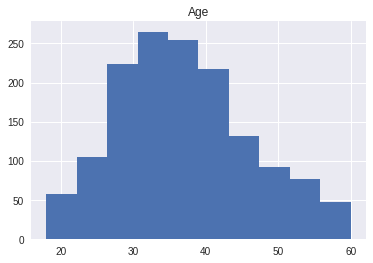

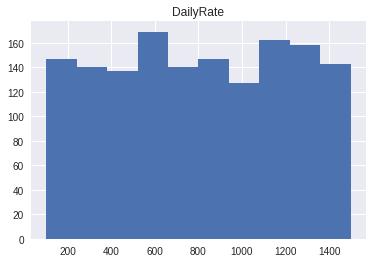

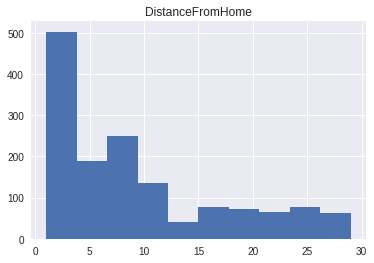

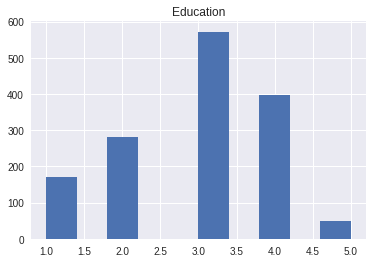

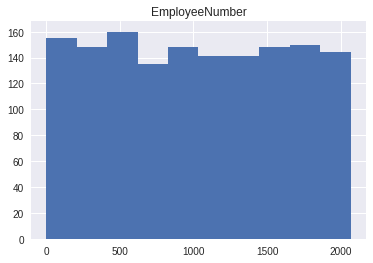

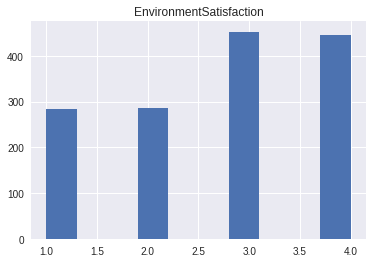

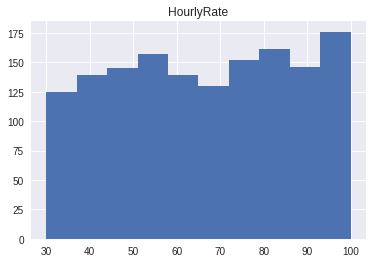

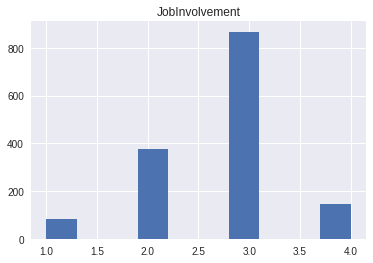

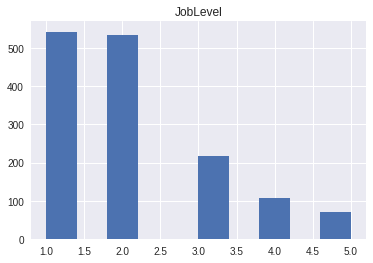

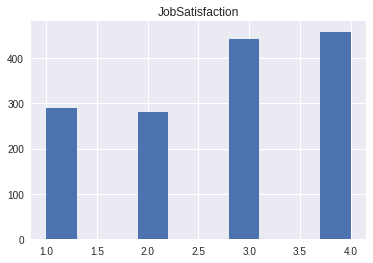

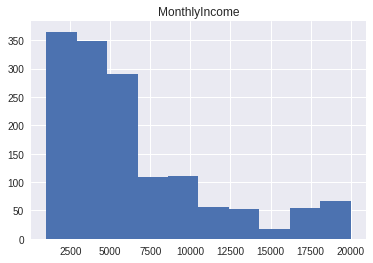

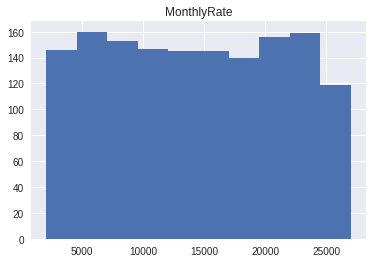

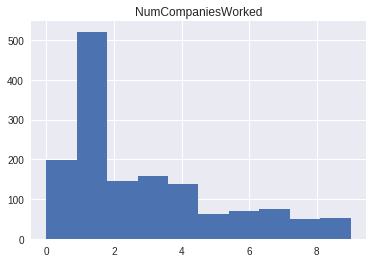

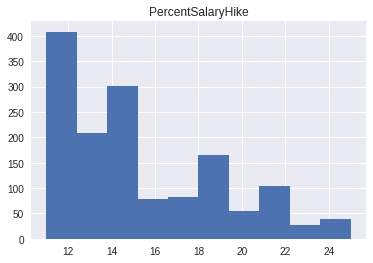

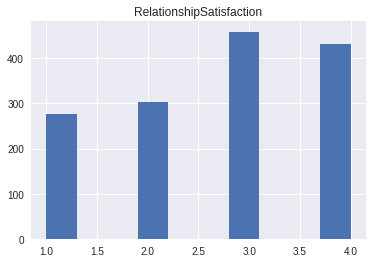

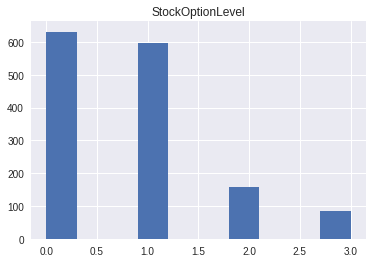

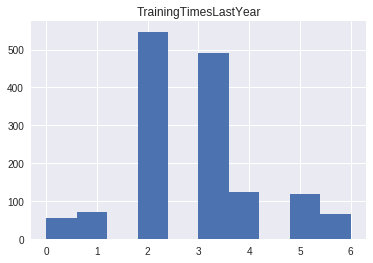

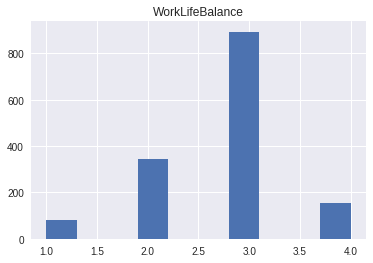

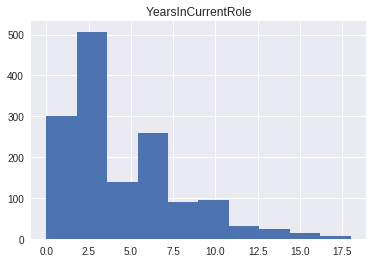

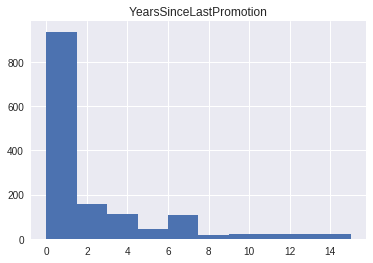

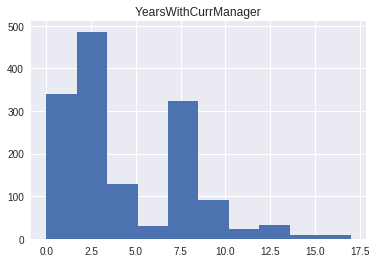

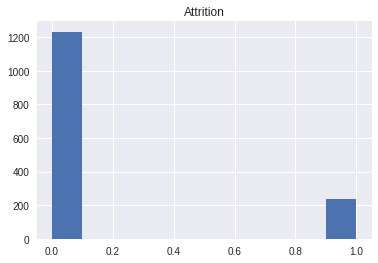

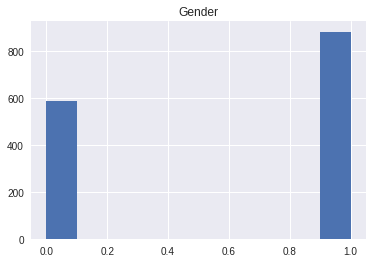

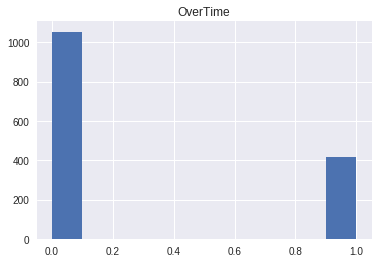

In [7]:
for i in data_numeric.columns:
  plt.hist(data_numeric[i])
  plt.title(i)
  plt.show()

In [8]:
# calculate variance as a percentage of mean and drop extremly high variance variables
var_percent = data_numeric.var()/data_numeric.mean()/100
print(var_percent[var_percent>1])

data_numeric = data_numeric.drop(var_percent[var_percent>1].index.values,axis=1)

DailyRate          2.028941
EmployeeNumber     3.536399
MonthlyIncome     34.084409
MonthlyRate       35.396152
dtype: float64


In [9]:
#now let's deal with objects that have more than 2 unique values
#if keep, then other get dummies, or make 2 unique values and encode
data_dummy.head()

,BusinessTravel,Department,EducationField,JobRole,MaritalStatus
0,Travel_Rarely,Sales,Life Sciences,Sales Executive,Single
1,Travel_Frequently,Research & Development,Life Sciences,Research Scientist,Married
2,Travel_Rarely,Research & Development,Other,Laboratory Technician,Single
3,Travel_Frequently,Research & Development,Life Sciences,Research Scientist,Married
4,Travel_Rarely,Research & Development,Medical,Laboratory Technician,Married


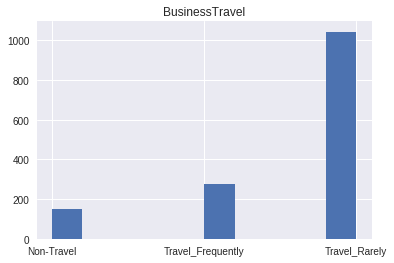

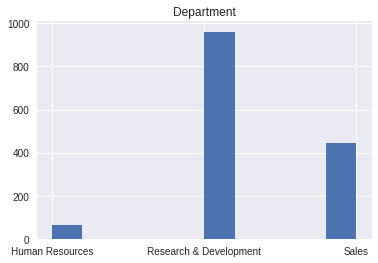

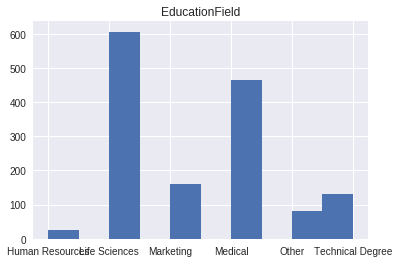

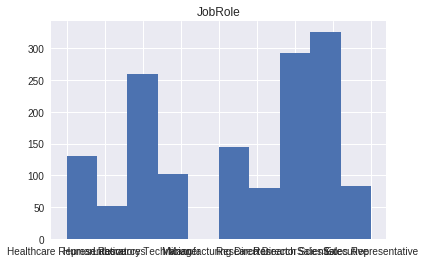

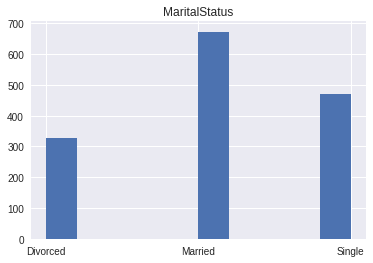

In [10]:
for i in data_dummy.columns:
  plt.hist(data_dummy[i])
  plt.title(i)
  plt.show()

In [0]:
#get dummies and drop sume to merge
data_dummy = pd.get_dummies(data_dummy,prefix=data_dummy.columns,drop_first=True)
data_dummy = data_dummy.drop(["BusinessTravel_Travel_Frequently","Department_Sales","MaritalStatus_Single"],axis=1)
data = data_numeric.join(data_dummy)

In [12]:
# are classes balanced?
data.Attrition.value_counts()/len(data)*100

0    83.877551
1    16.122449
Name: Attrition, dtype: float64

In [0]:
y = data.Attrition
x = data.drop("Attrition",axis=1)

# split 75% train and 25% test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.5,random_state=42)

In [0]:
model_tree = DecisionTreeClassifier(class_weight="balanced",random_state=42)
model_logit = LogisticRegression(class_weight="balanced",random_state=42)

In [15]:
tree_params = dict(max_depth=[i for i in range(3,10)], min_samples_leaf = [i for i in range(1,100,5)])
selector = GridSearchCV(model_tree, tree_params, cv=5, scoring="roc_auc")

selector.fit(x,y)
print(selector.best_params_)

{'max_depth': 6, 'min_samples_leaf': 31}


In [16]:
# Decision Tree
model_tree = DecisionTreeClassifier(max_depth=6,min_samples_leaf=31,class_weight="balanced",random_state=42)
model_tree.fit(x_train,y_train)
print("Tree scores")
print("========================")
print("Train: ",roc_auc_score(y_train, model_tree.predict(x_train))*100)
print("Test: ",roc_auc_score(y_test, model_tree.predict(x_test))*100)

print("\n") #break line in output

# Logistic Regression
model_logit.fit(x_train,y_train)
print("Logit scores")
print("========================")
print("Train: ",roc_auc_score(y_train, model_logit.predict(x_train))*100)
print("Test: ",roc_auc_score(y_test, model_logit.predict(x_test))*100)

Tree scores
Train:  76.22836160167861
Test:  68.43456662196756


Logit scores
Train:  78.01189019059277
Test:  74.08722418627332


In [17]:
tree_imp = pd.DataFrame(data=model_tree.feature_importances_.reshape(-1,1),index=x_train.columns,columns=["importance"])
tree_selected_feat = tree_imp[tree_imp.importance>0.01].index

# Decision Tree
model_tree.fit(x_train[tree_selected_feat],y_train)
print("Tree scores")
print("========================")
print("Train: ",roc_auc_score(y_train, model_tree.predict(x_train[tree_selected_feat]))*100)
print("Test: ",roc_auc_score(y_test, model_tree.predict(x_test[tree_selected_feat]))*100)

Tree scores
Train:  76.22836160167861
Test:  68.43456662196756


In [18]:
print("Decision tree mean CV ROC-AUC score is",np.round(np.mean(cross_val_score(model_tree,x,y,cv=5,scoring='roc_auc')),2)*100,"%")
print("Logistic Regression mean CV ROC-AUC score is",np.round(np.mean(cross_val_score(model_logit,x,y,cv=5,scoring='roc_auc')),2)*100,"%")

Decision tree mean CV ROC-AUC score is 76.0 %
Logistic Regression mean CV ROC-AUC score is 82.0 %
